In [6]:
%matplotlib inline

In [26]:
import glob
from io import BytesIO
from pathlib import Path
import re
from urllib.parse import urljoin
from zipfile import ZipFile

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import requests

# Retrieve the latest baby names dataset
The full baby names dataset is available from the SSA's website as three zip files.
https://www.ssa.gov/oact/babynames/limits.html

* National data
* State-specific data
* Territory-specific data

In [27]:
limits_url = 'https://www.ssa.gov/oact/babynames/limits.html'
r = requests.get(limits_url)
r.raise_for_status()
bs = BeautifulSoup(r.content, 'html5lib')

In [31]:
zips = {}
Path('data').mkdir(exist_ok=True)
for a in bs.find_all('a', {'href': lambda x: x.endswith('.zip')}):
    zip_url = urljoin(limits_url, a['href'])
    r = requests.get(zip_url)
    r.raise_for_status()
    with ZipFile(BytesIO(r.content)) as archive:
        archive.extractall('data')

In [36]:
!ls data

AK.TXT	NV.TXT		     yob1890.txt  yob1923.txt  yob1956.txt  yob1989.txt
AL.TXT	NY.TXT		     yob1891.txt  yob1924.txt  yob1957.txt  yob1990.txt
AR.TXT	NationalReadMe.pdf   yob1892.txt  yob1925.txt  yob1958.txt  yob1991.txt
AZ.TXT	OH.TXT		     yob1893.txt  yob1926.txt  yob1959.txt  yob1992.txt
CA.TXT	OK.TXT		     yob1894.txt  yob1927.txt  yob1960.txt  yob1993.txt
CO.TXT	OR.TXT		     yob1895.txt  yob1928.txt  yob1961.txt  yob1994.txt
CT.TXT	PA.TXT		     yob1896.txt  yob1929.txt  yob1962.txt  yob1995.txt
DC.TXT	PR.TXT		     yob1897.txt  yob1930.txt  yob1963.txt  yob1996.txt
DE.TXT	RI.TXT		     yob1898.txt  yob1931.txt  yob1964.txt  yob1997.txt
FL.TXT	SC.TXT		     yob1899.txt  yob1932.txt  yob1965.txt  yob1998.txt
GA.TXT	SD.TXT		     yob1900.txt  yob1933.txt  yob1966.txt  yob1999.txt
HI.TXT	StateReadMe.pdf      yob1901.txt  yob1934.txt  yob1967.txt  yob2000.txt
IA.TXT	TN.TXT		     yob1902.txt  yob1935.txt  yob1968.txt  yob2001.txt
ID.TXT	TR.TXT		     yob1903.txt  yob1936.txt  yob1969.txt  yo

Note that the latest national year-of-birth file is for 2019.

# Process the national data
We will load each national year-of-birth files, add columns for 

* the year (since this is implicit in the YOB file names), and
* the popularity rank of the name for the year. 

Then concatenate all the yearly data into a single table.

In [37]:
data = pd.DataFrame([], columns=['name', 'sex', 'count', 'rank', 'year'])
for filename in glob.glob('data/yob*.txt'):
    df = pd.read_csv(filename, header=None, names=["name", "sex", "count"])
    df['year'] = int(*re.findall(r'(\d+)', filename))
    df.loc[df['sex']=='F','rank'] = df.loc[df['sex']=='F','count'].rank(axis=0, method='min', ascending=False)
    df.loc[df['sex']=='M','rank'] = df.loc[df['sex']=='M','count'].rank(axis=0, method='min', ascending=False)
    data = data.append(df, sort=False)

In [38]:
data['rank'] = data['rank'].astype(int)

In [39]:
data.tail()

,name,sex,count,rank,year
31949,Zyheem,M,5,12080,2019
31950,Zykel,M,5,12080,2019
31951,Zyking,M,5,12080,2019
31952,Zyn,M,5,12080,2019
31953,Zyran,M,5,12080,2019


In [43]:
data = data.set_index(['name', 'year', 'sex']).unstack().unstack()

In [44]:
def plot_count(name, sex):
    return data.loc[name,:]['count'][sex].plot(
        grid=True, figsize=(10,10),
        title=('Boys' if sex == 'M' else 'Girls') + ' named ' + name)

In [45]:
def plot_rank(name, sex):
    plot = data.loc[name,:]['rank'][sex].plot(
        grid=True, figsize=(10,10),
        title='Popularity rank of ' + name + ' for ' + 
        ('Boys' if sex == 'M' else 'Girls'))
    plot.invert_yaxis()
    return plot

<AxesSubplot:title={'center':'Popularity rank of Eve for Girls'}, xlabel='year'>

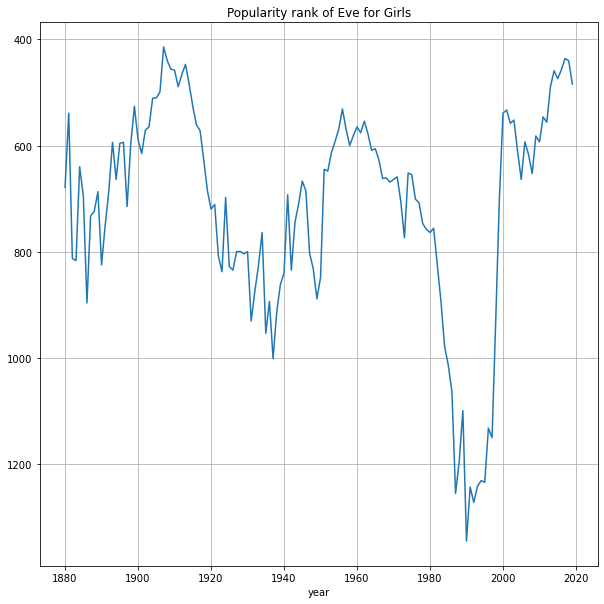

In [46]:
plot_rank('Eve', 'F')

<AxesSubplot:title={'center':'Popularity rank of Liam for Boys'}, xlabel='year'>

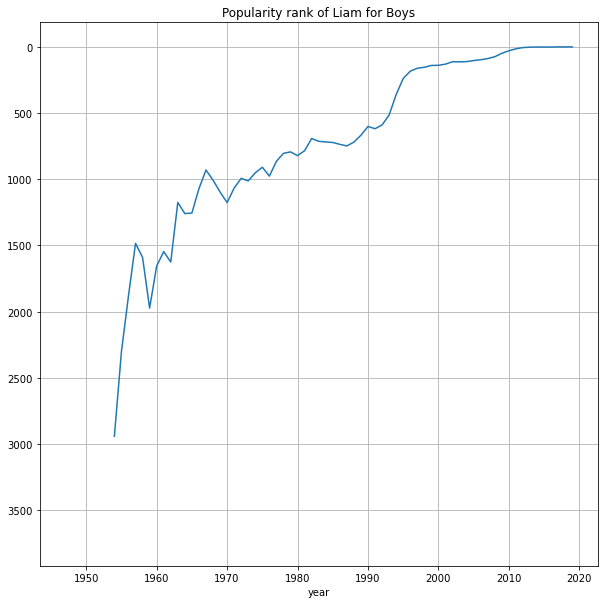

In [47]:
plot_rank('Liam', 'M')

<AxesSubplot:title={'center':'Boys named Liam'}, xlabel='year'>

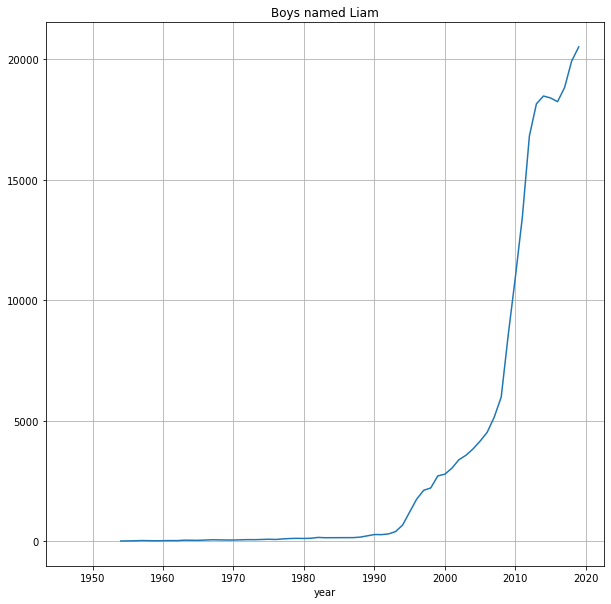

In [48]:
plot_count('Liam', 'M')

<AxesSubplot:title={'center':'Boys named Xander'}, xlabel='year'>

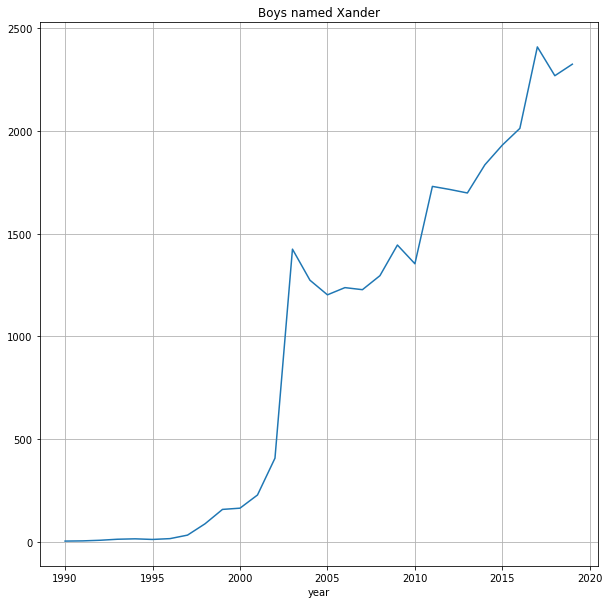

In [49]:
plot_count('Xander', 'M')

<AxesSubplot:title={'center':'Popularity rank of Xander for Boys'}, xlabel='year'>

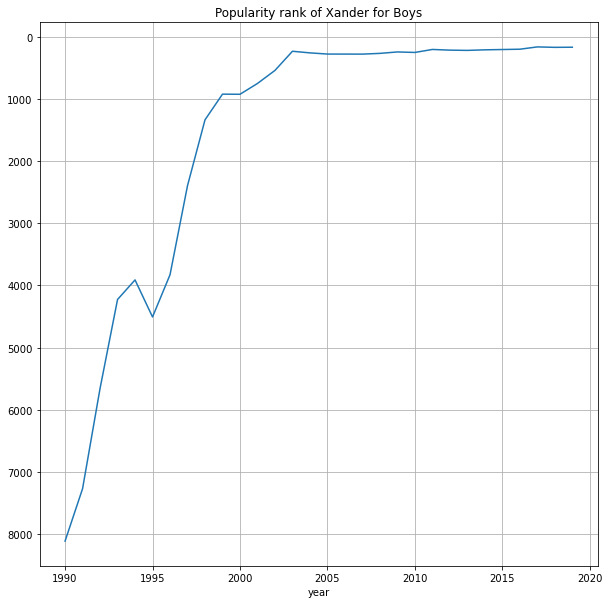

In [50]:
plot_rank('Xander', 'M')

(1980.0, 2018.0)

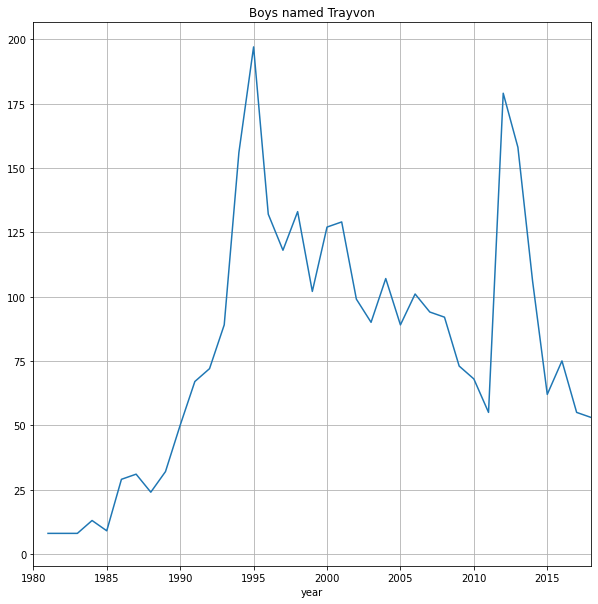

In [51]:
plot_count('Trayvon', 'M')
plt.xlim((1980,2018))

(1980.0, 2018.0)

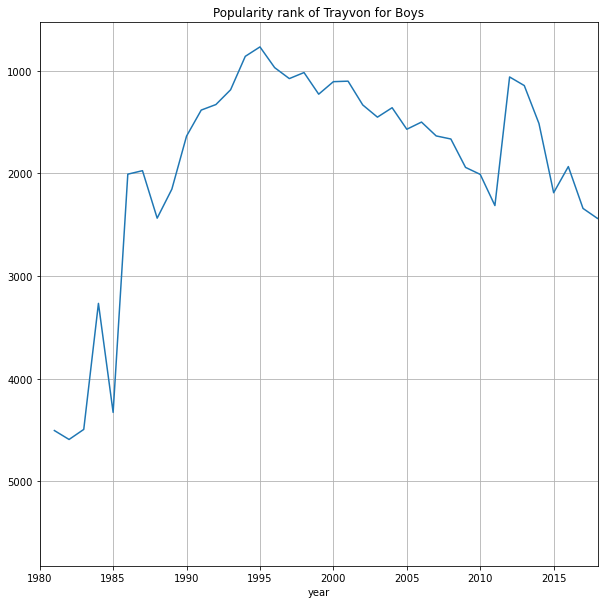

In [52]:
plot_rank('Trayvon', 'M')
plt.xlim((1980,2018))

## Write the data to CSV file

In [53]:
data.stack().stack().reset_index()[['name','sex','year','rank','count']].sort_values(
    ['rank','year']
).to_csv(
    'names_ranks_counts.csv', 
    index=False
)

# Process state data

In [59]:
state_data = pd.DataFrame([], columns=['state', 'sex', 'year', 'name', 'count', 'rank'])
for filename in glob.glob('data/[A-Z][A-Z].[Tt][Xx][Tt]'):
    df = pd.read_csv(filename, header=None, names=['state', 'sex', 'year', 'name', 'count'])
    for (year, sex), group in df.groupby(['year', 'sex'], sort=False):
        df.loc[group.index,'rank'] = group['count'].rank(axis=0, method='min', ascending=False)
    df.loc[:,'rank'] = df['rank'].astype(int)
    state_data = state_data.append(df)

## Write the data to CSV file

In [60]:
state_data.shape

(6147858, 6)

In [61]:
state_data['rank'] = state_data['rank'].astype(int)
state_data.sort_values(
    ['state', 'year', 'rank']
).to_csv(
    'namesbystate_ranks_counts.csv',
    index=False
)